# Results

In [1]:
from os import makedirs
from os.path import join

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator

plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{cmbright}',
    'text.usetex': True,
    'font.family': 'serif',
})
color = sns.color_palette('deep')

results_dir = '../rpaper'
plots_dir = 'paper_plots'

makedirs(plots_dir, exist_ok=True)

### Arch

In [2]:
def load_arch_df():
    df_extra = pd.DataFrame(
        [
            ['mobilenetv3-small-075', 'MobileNetV3-Small',  1.02,  0.12],
            ['mobilevitv2-050',       'MobileViTv2-0.5',    1.11,  1.05],
            ['mobilenetv3-large-100', 'MobileNetV3-Large',  4.20,  0.63],
            ['convnext-atto',         'ConvNeXtV1-Atto',    3.37,  1.62],
            ['convnextv2-atto',       'ConvNeXtV2-Atto',    3.39,  1.62],
            ['mobilevitv2-100',       'MobileViTv2-1.0',    4.39,  4.08],

            ['densenet121',           'Densenet121',        6.95,  8.33],
            ['mobilevitv2-200',       'MobileViTv2-2.0',   17.42, 16.11],
            ['convnextv2-nano',       'ConvNeXtV2-Nano',   14.98,  7.21],
            ['densenet161',           'Densenet161',       26.47, 22.70],
            ['convnext-tiny',         'ConvNeXtV1-Tiny',   27.82, 28.60],
            ['convnextv2-tiny',       'ConvNeXtV2-Tiny',   27.87, 28.60],
        ],
        columns=['run', 'Arch', 'Params', 'MACs']
    ).set_index('run')

    df = pd.read_csv(join(results_dir, 'arch_batch-size-64', 'exp_mtst.csv'))
    df = df.iloc[:, :4]
    df = df.rename(columns={'unseen': 'Unseen', 'seen': 'Seen', 'combined': 'All'})
    df['Unseen'] = df['Unseen'].str[:5].astype(float)
    df['Seen'] = df['Seen'].str[:5].astype(float)
    df['All'] = df['All'].str[:5].astype(float)
    df = df.set_index('run')

    df = pd.concat([df_extra, df], axis=1, join='inner')
    df = df[['Arch', 'Unseen', 'Seen', 'All', 'Params', 'MACs']]
    df = df.reset_index(drop=True)
    return df

arch_df = load_arch_df()
arch_df

,Arch,Unseen,Seen,All,Params,MACs
0,MobileNetV3-Small,84.42,92.76,90.24,1.02,0.12
1,MobileViTv2-0.5,86.68,93.47,91.38,1.11,1.05
2,MobileNetV3-Large,87.99,94.11,92.17,4.20,0.63
3,ConvNeXtV1-Atto,88.24,94.96,92.99,3.37,1.62
4,MobileViTv2-1.0,87.59,93.87,91.94,4.39,4.08
5,Densenet121,90.78,94.77,93.44,6.95,8.33
6,ConvNeXtV1-Tiny,89.62,94.99,93.46,27.82,28.60


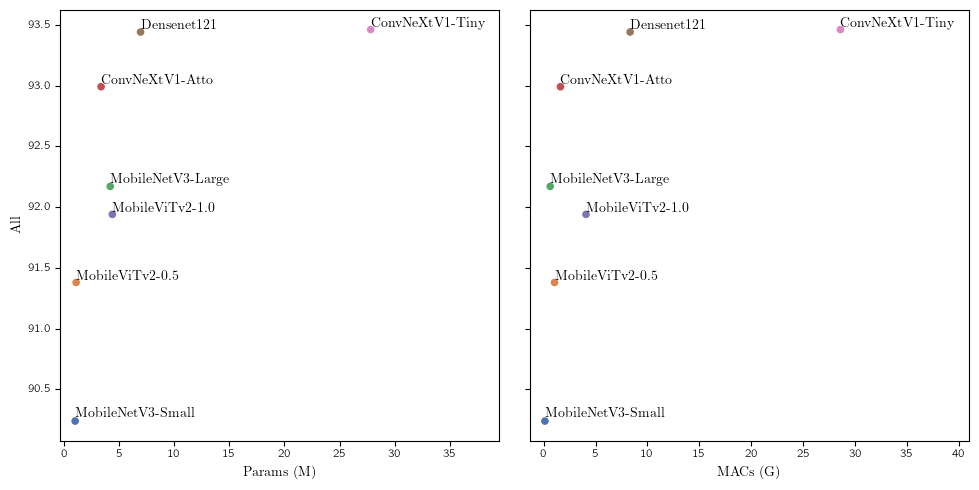

In [11]:
def generate_arch_plot(df):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

    _color = color[:len(df)]

    df.plot.scatter('Params', 'All',
                    ax=ax0, c=_color)
    df.plot.scatter('MACs', 'All',
                    ax=ax1, c=_color)

    for x, y, arch in zip(df['Params'], df['All'], df['Arch']):
        ax0.text(x, y, f'{arch}', ha='left', va='bottom')
    xmin, xmax = ax0.get_xlim()
    ax0.set_xlim(xmin, xmax + 0.35 * (xmax - xmin))
    ax0.tick_params(axis='both', which='major', labelsize='small')

    for x, y, arch in zip(df['MACs'], df['All'], df['Arch']):
        ax1.text(x, y, f'{arch}',
                ha='left', va='bottom')
    xmin, xmax = ax1.get_xlim()
    ax1.set_xlim(xmin, xmax + 0.35 * (xmax - xmin))
    ax1.tick_params(axis='both', which='major', labelsize='small')

    ax0.set_xlabel('Params (M)')
    ax1.set_xlabel('MACs (G)')
    ax1.set_yticklabels([])
    ax1.yaxis.label.set_visible(False)

    # plt.xticks(fontsize='small')
    # plt.yticks(fontsize='small')

    plt.tight_layout()
    plt.savefig(join(plots_dir, "params-macs.pdf"))
    plt.show()

generate_arch_plot(arch_df)

### Resolution

### From Generalized FSL to Standard FSL

In [4]:
def load_gfsl_df():
    df = pd.read_csv(join(results_dir, 'nway-unseen', 'exp_mtst.csv'))

    df[['n-way', 'n-unseen']] = df['run'].str.split('_', expand=True)
    df['n-way'] = df['n-way'].str[5:].astype(int)
    df['n-unseen'] = df['n-unseen'].str[7:].astype(int)
    df['Unseen'] = df['unseen'].str[:5].astype(float)
    df['Seen'] = df['seen'].str[:5].astype(float)
    df['All'] = df['combined'].str[:5].astype(float)
    df = df[['n-way', 'n-unseen', 'Unseen', 'Seen', 'All']]
    return df

gfsl_df = load_gfsl_df()
gfsl_df

,n-way,n-unseen,Unseen,Seen,All
0,3,1,88.29,94.14,92.25
1,3,2,68.90,87.67,76.79
2,3,3,56.53,NaN,56.53
3,4,1,84.78,95.36,93.24
4,4,2,71.95,91.42,83.30
5,4,3,63.17,85.97,70.97
6,4,4,56.03,NaN,56.03
7,5,1,81.87,95.79,93.70
8,5,2,73.21,92.71,86.45
9,5,3,66.48,89.50,77.76


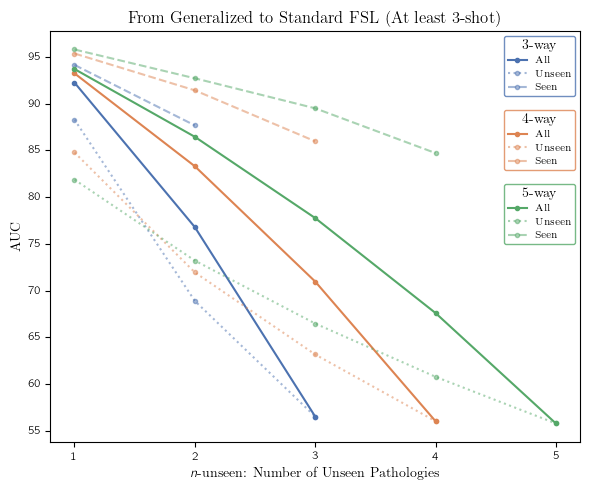

In [84]:
def generate_gfsl_df(df):
    sns.set_palette('deep')
    fig, ax = plt.subplots(figsize=(6, 5))

    for n_way, c in zip((3, 4, 5), color):
        n_way_label = f'{n_way}-way'
        subdf = df[df['n-way'] == n_way]
        # subdf = subdf.rename(columns={'All': n_way_label})
        # subdf.plot(x='n-unseen', y=n_way_label,
        #            style='o-', ax=ax, color=c)
        # subdf.plot(x='n-unseen', y='Unseen',
        #            style='s-', ax=ax, color=c, alpha=0.5)
        # subdf.plot(x='n-unseen', y='Seen',
        #            style='D-', ax=ax, color=c, alpha=0.5)

        subdf.plot(x='n-unseen', y='All',
                   ax=ax,
                   marker='.', linestyle='solid',
                   color=c)
        subdf.plot(x='n-unseen', y='Unseen',
                   ax=ax,
                   marker='.', linestyle='dotted',
                   color=c, alpha=0.5)
        subdf.plot(x='n-unseen', y='Seen',
                   ax=ax,
                   marker='.', linestyle='dashed',
                   color=c, alpha=0.5)

        ax.get_legend().remove()

        from matplotlib.legend import Legend
        leg = Legend(ax, ax.get_lines()[-3:],
                     ['All', 'Unseen', 'Seen'],
                     title=f'{n_way}-way',
                     fontsize='x-small',
                     edgecolor=c,
                     loc='upper right')
        bb = leg.get_bbox_to_anchor().transformed(ax.transAxes.inverted())
        y_offset = (3 - n_way) * 0.18
        bb.y0 += y_offset
        bb.y1 += y_offset
        leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
        ax.add_artist(leg)

    ax.set_xticks(range(1, 6))
    ax.tick_params(axis='both', which='major', labelsize='small')
    ax.set_xlabel(r'$n$-unseen: Number of Unseen Pathologies')
    ax.set_ylabel('AUC')

    plt.title('From Generalized to Standard FSL (At least 3-shot)')

    plt.tight_layout()
    plt.savefig(join(plots_dir, "gfsl.pdf"))
    plt.show()

generate_gfsl_df(gfsl_df)